### 作業目的: 使用樹型模型進行文章分類

本次作業主利用[Amazon Review data中的All Beauty](https://nijianmo.github.io/amazon/index.html)來進行review評價分類(文章分類)

資料中將review分為1,2,3,4,5分，而在這份作業，我們將評論改分為差評價、普通評價、優良評價(1,2-->1差評、3-->2普通評價、4,5-->3優良評價)

### 載入套件

In [1]:
import json
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

### 資料前處理
文本資料較為龐大，這裡我們取前10000筆資料來進行作業練習

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen

In [4]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/All_Beauty.json.gz

In [5]:
#load json data
all_reviews = []
path = 'All_Beauty.json.gz'

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

all_reviews = getDF(path)

all_reviews.iloc[1]

overall                                                           4
verified                                                       True
reviewTime                                              12 18, 2014
reviewerID                                           A2F5GHSXFQ0W6J
asin                                                     0143026860
reviewerName                                           Mary K. Byke
reviewText        My  husband wanted to reading about the Negro ...
summary           ... to reading about the Negro Baseball and th...
unixReviewTime                                           1418860800
vote                                                            NaN
style                                                           NaN
image                                                           NaN
Name: 1, dtype: object

In [6]:
all_reviews.iloc[5]

overall                                                           5
verified                                                      False
reviewTime                                              02 26, 2010
reviewerID                                           A36NF437WZLQ9E
asin                                                     0143026860
reviewerName                                              W. Powell
reviewText        Today I gave a book about the Negro Leagues of...
summary                                  The Gift of Black Baseball
unixReviewTime                                           1267142400
vote                                                              4
style                                                           NaN
image                                                           NaN
Name: 5, dtype: object

In [7]:
ratings = []

for review in parse(path):
  ratings.append(review['overall'])

print(sum(ratings) / len(ratings))

4.112092528511223


In [145]:
from collections import Counter

def get_label_ratio(reviews):
    rating_dict = Counter(reviews['overall'].to_list())
    total_num = len(reviews)
    print([(k,round(rating_dict[k]/total_num,2)) for k in sorted(rating_dict.keys())])

# get the ratio of labels, see if it is unbalanced
get_label_ratio(all_reviews)
get_label_ratio(all_reviews[:10000])

# select those ratio for each comment
# because other one will be merge, so select rating 3 more
0.1875, 0.1875, 0.25, 0.1875, 0.1875
round(10000 * 0.375)


[(1.0, 0.11), (2.0, 0.05), (3.0, 0.08), (4.0, 0.14), (5.0, 0.62)]
[(1.0, 0.04), (2.0, 0.03), (3.0, 0.04), (4.0, 0.13), (5.0, 0.76)]


3750

In [ ]:
#define a sampler function
def sampler(df, ratio_for_3=0.25, sample_size=10000):
    reviews = pd.DataFrame()
    for i in range(1,6):
        other_ratio = round(sample_size * (1 - ratio_for_3) / 4)
        print(other_ratio)
        if i == 3:
            review = df[df['overall'] == i]
            print(sample_size - other_ratio*4)
            review = review[:(sample_size - other_ratio*4)]
            reviews = pd.concat([reviews,review], axis=0)
        else:
            review = df[df['overall'] == i]
            review = review[:other_ratio]
            reviews = pd.concat([reviews,review], axis=0)
    return reviews

reviews_new_sample = sampler(all_reviews)
get_label_ratio(reviews_new_sample)
reviews_new_sample.head()

In [85]:
# convert the function to fit the pipline module
class samplerTransforer(BaseEstimator, TransformerMixin):
    def __init__(self, ratio_for_3=0.25, sample_size=10000):
        self.ratio_for_3 = ratio_for_3
        self.sample_size = sample_size
    def fit(self, X, y=None):
        self.reviews = pd.DataFrame()
        return self
    def transform(self, X, y=None):
        for i in range(1,6):
            other_ratio = round(self.sample_size * (1 - self.ratio_for_3) / 4)
            if i == 3:
                review = X[X['overall'] == i]
                review = review[:(self.sample_size - other_ratio*4)]
                self.reviews = pd.concat([self.reviews,review], axis=0)
            else:
                review = X[X['overall'] == i]
                review = review[:other_ratio]
                self.reviews = pd.concat([self.reviews,review], axis=0)
        get_label_ratio(self.reviews)
        return self.reviews


samp = samplerTransforer(ratio_for_3=0.25, sample_size=30000)
reviews_new_sample = samp.fit_transform(all_reviews)


reviews_new_sample

[(1.0, 0.19), (2.0, 0.19), (3.0, 0.25), (4.0, 0.19), (5.0, 0.19)]


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"02 19, 2015",A1V6B6TNIC10QE,0143026860,theodore j bigham,great,One Star,1424304000,NaN,NaN,NaN
7,1.0,True,"04 10, 2017",A26PO1B2Q2G1CS,014789302X,Jacqueline Diaz,I didn't like this product it smudged all unde...,One Star,1491782400,NaN,NaN,NaN
9,1.0,True,"11 19, 2016",AMACNEW14ADMX,014789302X,rabiyaa123,it burns your eyes when u put it on and very ...,i do not recommend.,1479513600,3,NaN,NaN
68,1.0,True,"03 24, 2018",A58290JXH0SSU,1620213982,Skip,It rusts.,It rusts.,1521849600,NaN,{'Size:': ' 6.25 Inches'},NaN
80,1.0,True,"03 14, 2018",AQXFXUIO73LH3,1620213982,VB,Bought it as a present...doesn't fit a standar...,One Star,1520985600,NaN,{'Size:': ' 6.25 Inches'},NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6802,5.0,False,"09 13, 2007",A1VEY17U6ELHVT,B000052Y8Z,S. L. Patten,"Works great for repairing teeth. Easy to use,...",dentemp o.s.,1189641600,4,NaN,NaN
6803,5.0,False,"06 1, 2007",A12PZSAJ3KZUBA,B000052Y8Z,J. Trenton Hardy,I have used this product for 10 years now. As ...,The best you can buy ! Bar none!!!,1180656000,16,NaN,NaN
6812,5.0,True,"09 27, 2012",A2JLFJPBQUG6K1,B000052Y8Z,verlie,I was very pleased with this product I threw i...,temp filling kit,1348704000,NaN,NaN,NaN
6814,5.0,False,"09 5, 2012",AVDQFRI1SLEYG,B000052Y8Z,silentpest,"i use it for a crown that comes out at times ,...",IT WORKS,1346803200,NaN,NaN,NaN


In [128]:
reviews_sample = all_reviews[:10000]

In [129]:
#parse label(overall) and corpus(reviewText)
corpus = reviews_sample['reviewText'].to_list()

#transform labels: 1,2 --> 1 and 3 --> 2 and 4,5 --> 3
# method1:
conversion_dict = {
    1:1,
    2:1,
    3:2,
    4:3,
    5:3
}
labels = reviews_sample['overall'].apply(lambda x: conversion_dict[x])
# method2
labels_method2 = all_reviews['overall'].apply(lambda x : 1 if x==2 else(x//2+1))
labels_check = all_reviews['overall']
print(pd.concat([labels_check,labels,labels_method2], axis=1).head(11))
        
labels = labels.to_list()
labels[:10]

    overall  overall  overall
0       1.0      1.0      1.0
1       4.0      3.0      3.0
2       4.0      3.0      3.0
3       5.0      3.0      3.0
4       5.0      3.0      3.0
5       5.0      3.0      3.0
6       4.0      3.0      3.0
7       1.0      1.0      1.0
8       5.0      3.0      3.0
9       1.0      1.0      1.0
10      2.0      1.0      1.0


[1, 3, 3, 3, 3, 3, 3, 1, 3, 1]

In [86]:
corpus_new = reviews_new_sample['reviewText'].to_list()
conversion_dict = {1:1, 2:1, 3:2, 4:3, 5:3}
labels_new = reviews_new_sample['overall'].apply(lambda x: conversion_dict[x])
corpus_new[:5] ,labels_new[:5]

(['great',
  "I didn't like this product it smudged all under my eyes throughly the day",
  'it burns your eyes when u put it on  and very light so u have to keep going back n forth a lot to get the dark eyeliner color.\nalso it smudges lot. waste of money.',
  'It rusts.',
  "Bought it as a present...doesn't fit a standard Gillette razor"],
 0     1
 7     1
 9     1
 68    1
 80    1
 Name: overall, dtype: int64)

In [10]:
print(len(corpus))
corpus[:5]

10000


['great',
 "My  husband wanted to reading about the Negro Baseball and this a great addition to his library\n Our library doesn't haveinformation so this book is his start. Tthank you",
 'This book was very informative, covering all aspects of game.',
 'I am already a baseball fan and knew a bit about the Negro leagues, but I learned a lot more reading this book.',
 "This was a good story of the Black leagues. I bought the book to teach in my high school reading class. I found it very informative and exciting. I would recommend to anyone interested in the history of the black leagues. It is well written, unlike a book of facts. The McKissack's continue to write good books for young audiences that can also be enjoyed by adults!"]

In [11]:
#preprocessing data
#remove email address, punctuations, and change line symbol(\n)
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import numpy as np
import re
from nltk.stem.porter import *
stemmer = PorterStemmer()

class ReviewToWordCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, remove_punctuation=True, replace_numbers=True, stemming=True):
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for review in X:
            text = str(review) or ''
            if self.lower_case:
                text = text.lower()
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)


In [12]:
transformer = ReviewToWordCountTransformer()
corpus_transform = transformer.fit_transform(corpus)
corpus_transform


array([Counter({'great': 1}),
       Counter({'to': 2, 'thi': 2, 'hi': 2, 'librari': 2, 'my': 1, 'husband': 1, 'want': 1, 'read': 1, 'about': 1, 'the': 1, 'negro': 1, 'basebal': 1, 'and': 1, 'a': 1, 'great': 1, 'addit': 1, 'our': 1, 'doesn': 1, 't': 1, 'haveinform': 1, 'so': 1, 'book': 1, 'is': 1, 'start': 1, 'tthank': 1, 'you': 1}),
       Counter({'thi': 1, 'book': 1, 'wa': 1, 'veri': 1, 'inform': 1, 'cover': 1, 'all': 1, 'aspect': 1, 'of': 1, 'game': 1}),
       ..., Counter({'excel': 1, 'product': 1}),
       Counter({'best': 1, 'stuff': 1, 'on': 1, 'earth': 1, 'for': 1, 'your': 1, 'hair': 1}),
       Counter({'it': 4, 'love': 2, 'i': 2, 'use': 2, 'as': 2, 'thi': 1, 'cream': 1, 'have': 1, 'been': 1, 'for': 1, 'over': 1, 'number': 1, 'year': 1, 'and': 1, 'will': 1, 'continu': 1, 'to': 1, 'long': 1, 'is': 1, 'avail': 1})],
      dtype=object)

In [130]:
#split corpus and label into train and test
from sklearn.model_selection import train_test_split

# because we are going to use the pipeline later, so we give up the corpus_transform in this stage
x_train, x_test, y_train, y_test = train_test_split(corpus ,labels, test_size = 0.2, random_state = 42)

len(x_train), len(x_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

In [14]:
from scipy.sparse import csr_matrix
class WordCountToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word]  += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common = most_common
        self.vocabulary_ = {word : index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word,0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [15]:
vocab_transformer = WordCountToVectorTransformer(vocabulary_size = 30)
X_few_vectors = vocab_transformer.fit_transform(x_train[:30])
X_few_vectors.toarray()

array([[ 20,   0,   1,   2,   3,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [ 16,   0,   2,   0,   1,   0,   0,   1,   0,   0,   0,   0,   2,
          0,   1,   0,   0,   0,   0,   2,   0,   0,   0,   1,   0,   0,
          0,   0,   0,   0,   0],
       [ 18,   1,   1,   1,   3,   1,   2,   0,   2,   0,   0,   2,   1,
          0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   3,   2,   1,
          1,   0,   0,   0,   0],
       [  7,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   1,   0,   0,   2],
       [ 10,   1,   1,   0,   1,   1,   0,   0,   0,   0,   1,   1,   0,
          0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   1,   0,   0],
       [  3,   0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   1,   1,   0,

In [16]:
vocab_transformer.vocabulary_

{'the': 1,
 'and': 2,
 'it': 3,
 'a': 4,
 'i': 5,
 'is': 6,
 'my': 7,
 'for': 8,
 'to': 9,
 'use': 10,
 'thi': 11,
 'great': 12,
 'of': 13,
 'razor': 14,
 'clean': 15,
 'up': 16,
 'in': 17,
 'batteri': 18,
 'shave': 19,
 'nice': 20,
 'have': 21,
 'that': 22,
 'number': 23,
 'product': 24,
 'be': 25,
 'on': 26,
 'not': 27,
 'with': 28,
 'are': 29,
 'solut': 30}

In [131]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ('text_to_wordcount', ReviewToWordCountTransformer()),
    ('wordcount_to_vector', WordCountToVectorTransformer(vocabulary_size=2000)),
])

X_train_transformed = preprocess_pipeline.fit_transform(x_train)

In [133]:
#change corpus into vector
#you can use tfidf or BoW here

###<your code>###

#transform training and testing corpus into vector form
x_train = X_train_transformed
x_test = preprocess_pipeline.transform(x_test)

In [73]:
x_test.toarray()

array([[128,  32,   0, ...,   0,   0,   0],
       [  3,   0,   3, ...,   0,   0,   0],
       [  1,   0,   1, ...,   0,   0,   0],
       ...,
       [  2,   1,   4, ...,   0,   0,   0],
       [  2,   0,   1, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

### 訓練與預測

In [134]:
#build classification model (decisionadaboost tree, random forest, or adaboost)
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from time import time

tree_clf = DecisionTreeClassifier()
rand_clf = RandomForestClassifier(n_jobs=-1)
ada_clf = AdaBoostClassifier()

t1 = time()
#start training
tree_clf.fit(x_train, y_train)
print(time() - t1)

t1 = time()
#start training
rand_clf.fit(x_train, y_train)
print(time() - t1)

t1 = time()
#start training
ada_clf.fit(x_train, y_train)
print(time() - t1)
###<your code>###

0.6682517528533936
0.7718179225921631
0.4523158073425293


In [135]:
#start inference
tree_pred = tree_clf.predict(x_test)
rand_pred = rand_clf.predict(x_test)
ada_pred = ada_clf.predict(x_test)

voter = np.argmax((tree_pred, rand_pred, ada_pred),axis=0)
print(voter)
print(sum(y_test == voter)/len(voter))

[0 0 0 ... 0 0 1]
0.024


In [136]:
print('Accuracy for tree', tree_clf.score(x_test,y_test))
print('Accuracy for forest', rand_clf.score(x_test,y_test))
print('Accuracy for ada', ada_clf.score(x_test,y_test))

Accuracy for tree 0.8685
Accuracy for forest 0.904
Accuracy for ada 0.907


In [137]:
#calculate confusion matrix, precision, recall, and f1-score
print('\n\npredit for tree\n' + '~'*50)
print(classification_report(y_test, tree_pred))
print('\n\npredit for random forest\n'+ '~'*50)
print(classification_report(y_test, rand_pred))
print('\n\npredit for adaboost\n'+ '~'*50)
print(classification_report(y_test, ada_pred))




predit for tree
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           1       0.42      0.40      0.41       144
           2       0.13      0.11      0.12        73
           3       0.93      0.94      0.93      1783

    accuracy                           0.87      2000
   macro avg       0.49      0.48      0.49      2000
weighted avg       0.86      0.87      0.87      2000



predit for random forest
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

           1       0.84      0.19      0.31       144
           2       1.00      0.01      0.03        73
           3       0.90      1.00      0.95      1783

    accuracy                           0.90      2000
   macro avg       0.92      0.40      0.43      2000
weighted avg       0.90      0.90      0.87      2000



predit for adaboost
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              prec

In [138]:
import matplotlib.pyplot as plt



confusion matrix for tree
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[ 0 12 75]
 [11  0 54]
 [68 43  0]]


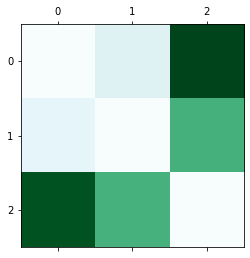



confusion matrix for rand
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[  0   0 117]
 [  2   0  70]
 [  3   0   0]]


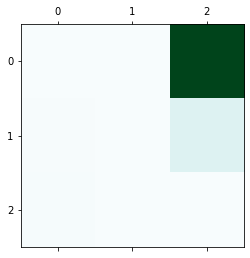



confusion matrix for ada
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[ 0  1 88]
 [ 6  0 60]
 [26  5  0]]


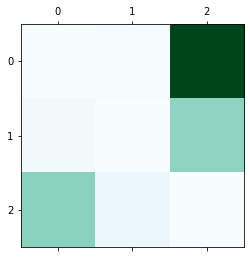

In [139]:
row_sums_tree = tree_conf.sum(axis = 1, keepdims = True)
tree_conf = confusion_matrix(y_test, tree_pred)
np.fill_diagonal(tree_conf,0)

row_sums_forest = forest_conf.sum(axis = 1, keepdims = True)
forest_conf = confusion_matrix(y_test, rand_pred)
np.fill_diagonal(forest_conf,0)

row_sums_ada = ada_conf.sum(axis = 1, keepdims = True)
ada_conf = confusion_matrix(y_test, ada_pred)
np.fill_diagonal(ada_conf,0)

print('\n\nconfusion matrix for tree\n' + '~'*50)
print(tree_conf)
plt.matshow(tree_conf / row_sums_tree, cmap=plt.cm.BuGn)
plt.show()

print('\n\nconfusion matrix for rand\n' + '~'*50)
print(forest_conf)
plt.matshow(forest_conf / row_sums_forest, cmap=plt.cm.BuGn)
plt.show()

print('\n\nconfusion matrix for ada\n' + '~'*50)
print(ada_conf)
plt.matshow(ada_conf / row_sums_ada, cmap=plt.cm.BuGn)
plt.show()

In [ ]:
由上述資訊可以發現, 模型在好評的準確度高(precision, recall都高), 而在差評的部分表現較不理想, 在普通評價的部分大部分跟差評搞混,
同學可以試著學習到的各種方法來提升模型的表現

In [ ]:
# seems like we get a good result here, but is it?
#let's banance the review

In [140]:
samp = samplerTransforer(ratio_for_3=0.25, sample_size=30000)
reviews_new_sample = samp.fit_transform(all_reviews)

corpus_new = reviews_new_sample['reviewText'].to_list()
conversion_dict = {1:1, 2:1, 3:2, 4:3, 5:3}
labels_new = reviews_new_sample['overall'].apply(lambda x: conversion_dict[x])

x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(corpus_new ,labels_new, test_size = 0.2, random_state = 42)

X_test_transformed = preprocess_pipeline.transform(x_test_balanced)


[(1.0, 0.19), (2.0, 0.19), (3.0, 0.25), (4.0, 0.19), (5.0, 0.19)]


In [141]:
print('Accuracy for tree', tree_clf.score(X_test_transformed,y_test_balanced))
print('Accuracy for forest', rand_clf.score(X_test_transformed,y_test_balanced))
print('Accuracy for ada', ada_clf.score(X_test_transformed,y_test_balanced))

Accuracy for tree 0.4995
Accuracy for forest 0.428
Accuracy for ada 0.4665


In [165]:
#train this again
X_train_transformed = preprocess_pipeline.transform(x_train_balanced)
tree_clf.fit(X_train_transformed, y_train_balanced)
rand_clf.fit(X_train_transformed, y_train_balanced)
ada_clf.fit(X_train_transformed, y_train_balanced)

AdaBoostClassifier()

In [166]:
#did we get better result?
print('Accuracy for tree', tree_clf.score(X_test_transformed,y_test_balanced))
print('Accuracy for forest', rand_clf.score(X_test_transformed,y_test_balanced))
print('Accuracy for ada', ada_clf.score(X_test_transformed,y_test_balanced))

Accuracy for tree 0.6046666666666667
Accuracy for forest 0.5956666666666667
Accuracy for ada 0.628


In [196]:
from sklearn.model_selection import RandomizedSearchCV ,GridSearchCV
from sklearn.metrics import coverage_error

dct = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator=dct)
param_grid = {
    'base_estimator__max_depth':[4,5,6,7,8],
    'base_estimator__min_samples_split':list(range(5,51,5)),
    'base_estimator__min_samples_leaf':list(range(3,20)),
    'base_estimator__splitter' :   ["best", "random"],
    'n_estimators': list(range(80,200,5)),
    'learning_rate': [0.1*x for x in range(3,10)]
}
random_search = GridSearchCV(ada, param_grid, cv=3, scoring='f1_macro',n_jobs=-1)
random_search.fit(X_train_transformed, y_train_balanced)
# ada.fit(X_train_transformed, y_train_balanced)
# print('Accuracy for ada', ada.score(X_test_transformed,y_test_balanced))

KeyboardInterrupt: 

In [ ]:
random_search.cv_results_